In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl

In [2]:
os.chdir('/home/users/richras/Ge2Net_Repo')
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'
os.environ['WANDB_DIR']='/scratch/users/richras/Batch_jobs/wandb'
os.environ['IMAGE_PATH']='/scratch/groups/cdbustam/richras/images'

In [98]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '/home/users/richras/Ge2Net_Repo')
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows,\
getValueBySelection
from src.utils.modelUtil import Params, load_model
from src.utils.labelUtil import repeat_pop_arr
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
seed = 1233
np.random.seed(seed)

In [29]:
config={}
config['data.data_in'] = '/scratch/groups/cdbustam/richras/data_in'
config['data.data_out'] = '/scratch/groups/cdbustam/richras/data_out'
config['data.data_dir'] = '/scratch/groups/cdbustam/richras'
data_id = '7_pca'
train_expt_id = 1
model="Model_B"
config['data.labels_dir'] = ''.join(['/scratch/groups/cdbustam/richras/data_out/humans/labels/',\
                                    'data_id_', str(data_id)])
config['model.working_dir'] = ''.join(['/scratch/groups/cdbustam/richras/data_out/humans/training/',\
                            str(model),'_exp_id_',str(train_expt_id),'_data_id_', str(data_id),'/models_dir' ])
# config['data.params'] =  ''.join(['/scratch/groups/cdbustam/richras/data_out/humans/training/',\
#                             str(model),'_exp_id_',str(train_expt_id),'_data_id_', str(data_id)]) 

config['data.params'] = '/home/users/richras/Ge2Net_Repo/src/main/experiments/exp_B/'

config['cuda'] = 'cuda:0'
config['geno_type'] ='humans'

# json_path = os.path.join(config['data.params'], 'params.json')
#incorrect below- tmp workaround. find the issue and revert back to above
json_path = ''.join([config['data.params'], 'params.json'])
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.cuda = torch.cuda.is_available()
params.device = torch.device(config['cuda'] if params.cuda else 'cpu')
params.n_win=605

In [30]:
model_aux = AuxiliaryTask.AuxNetwork(params).to(params.device)
model_main = LSTM.BiRNN(params).to(params.device)
model_cp = BasicBlock.logits_Block(params).to(params.device)
model_path = osp.join(config['model.working_dir'], 'best.pt')
model_ls = [model_aux, model_main, model_cp]

model_ret = load_model(model_path, model_ls)
model = Model_B.model_B(*model_ret, params=params)

best val accuracy : t_accr(l1_loss=0.6200863448031272, mse_loss=0.5297660646655398, smoothl1_loss=0.25396062570059547, weighted_loss=0.6200863448031272, loss_main=tensor(0.6201, device='cuda:0', dtype=torch.float64), loss_aux=tensor(0.6201, device='cuda:0', dtype=torch.float64), residual_loss=None, gcdLoss=None, accAtGcd=None)
at epoch : 84
train accuracy: t_accr(l1_loss=0.7241407972852167, mse_loss=0.7447887036533791, smoothl1_loss=0.3687372617126149, weighted_loss=0.7241407972852167, loss_main=0.1225475316969766, loss_aux=tensor(0.5265, device='cuda:0'), residual_loss=None, gcdLoss=None, accAtGcd=None)
best val accuracy : t_cp_accr(loss_cp=0.4528770903279959, Precision=0.9231979915499664, Recall=0.9191177713383937, BalancedAccuracy=-inf)
train accuracy: t_cp_accr(loss_cp=0.3048695237311589, Precision=0.9251727792277558, Recall=0.9496311840472299, BalancedAccuracy=nan)
best val accuracy : None
train accuracy: None
best val accuracy : None
train accuracy: None


In [31]:
from src.main.dataset import Haplotype

labels_path = config['data.labels_dir']
training_dataset = Haplotype('train', params, labels_path)
validation_dataset = Haplotype('valid', params, labels_path)
test_dataset = Haplotype('test', params, labels_path)

Finished 'load_data' in 232.5492 secs
Finished 'load_data' in 69.5727 secs
Finished 'load_data' in 50.4330 secs


In [32]:
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=params.batch_size, shuffle=True,
                                                    num_workers=0)
validation_generator = torch.utils.data.DataLoader(validation_dataset, batch_size=params.batch_size, num_workers=0)

test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=params.batch_size, num_workers=0)

In [33]:
val_labels = validation_dataset.vcf_idx
eval_result = model.valid(validation_generator, plot_obj=None)


/home/users/richras/Ge2Net_Repo/src/main/evaluation.py:79: RuntimeWarning: divide by zero encountered in long_scalars
  A_no_cp = TN_count/(TN_count + FP_count)


Finished 'valid' in 35.7278 secs


In [34]:
test_labels = test_dataset.vcf_idx
test_result = model.valid(test_generator, plot_obj=None)

/home/users/richras/Ge2Net_Repo/src/main/evaluation.py:79: RuntimeWarning: divide by zero encountered in long_scalars
  A_no_cp = TN_count/(TN_count + FP_count)


Finished 'valid' in 31.6803 secs


In [ ]:
train_labels = training_dataset.vcf_idx
train_result = model.valid(training_generator, plot_obj=None)

In [35]:
valid_outs= eval_result.t_out
print(valid_outs.coord_main.shape)
print(valid_outs.y_var.shape)
val_target_labels = validation_dataset.data['y']

(3650, 605, 3)
(3650, 605, 3)


In [36]:
test_outs= test_result.t_out
print(test_outs.coord_main.shape)
print(test_outs.y_var.shape)
test_target_labels = test_dataset.data['y']
test_vcf_idx=test_dataset.vcf_idx

(2964, 605, 3)
(2964, 605, 3)


In [37]:
val_vcf_idx=validation_dataset.vcf_idx
val_vcf_idx.shape

(3650, 605169)

In [38]:
granular_pop_dict = load_path(osp.join(config['data.labels_dir'], 'granular_pop.pkl'), en_pickle=True)
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
pop_sample_map=pd.read_csv(osp.join(config['data.labels_dir'], 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
superpop_dict = load_path(osp.join(config['data.labels_dir'], 'superpop.pkl'), en_pickle=True)
labels_dict=load_path(osp.join(config['data.labels_dir'], 'labels.pkl'), en_pickle=True)

In [294]:
def plot_sample(y_pred_overall,y_vcf_idx_raw,y_target, pop_arr,rev_pop_dict, superpop_dict, all_labels, \
                labels_path, cp_show):
    mpl.rcParams['axes.spines.left'] = False
    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.bottom'] = False
    fig, ax = plt.subplots(figsize=(14,15))
    plt.xticks([])
    plt.yticks([])
    gs1 = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[14,4])
    ax=fig.add_subplot(gs1[0:,:],projection='3d')
#     ax1=fig.add_subplot(gs1[1])
    ax2=fig.add_subplot(gs1[1])
    plt.subplots_adjust(hspace=10)
    
    num_labels_idx = np.unique(y_vcf_idx_raw)
    colors_pop = sns.color_palette("rainbow", len(num_labels_idx))
    colors_pop_dict = {k:v for k,v in zip(num_labels_idx, colors_pop)}
    
    j =0

    gradient_cp_idx = np.unique(np.where(abs(y_pred_overall[:-1,:]-y_pred_overall[1:,:])>0.6)[0])
    print(f"number of windows removed as cp:{len(gradient_cp_idx)}")

    colors_pop_all = sns.color_palette("pastel", len(superpop_dict))
    plot1=[]
    for k,i in superpop_dict.items():
        idx_label = np.nonzero(pop_arr[:,3]==i)[0]
        sample_cnt = 300
        if len(idx_label)>sample_cnt:
            idx_label2 = np.random.choice(idx_label,sample_cnt)
        else:
            idx_label2 = idx_label
        plot1.append(ax.scatter(all_labels[idx_label2,0], all_labels[idx_label2,1], all_labels[idx_label2,2], s=10,\
                color=colors_pop_all[i] , marker=".",label = k, alpha=0.1, zorder=1))
    lgnd1 = ax.legend(handles=plot1,bbox_to_anchor=(0.88,0.6))
    for l in lgnd1.legendHandles:
        l.set_alpha(1.0)
        l._sizes = [100]
        
    ax.add_artist(lgnd1)
    
    plot2=[]
    for i, val in enumerate(num_labels_idx):
        idx_label = np.nonzero(y_vcf_idx==val)[1]
        pop_arr_idx = (np.where(pop_arr[:,1]==val)[0]).item()
        granular_pop = pop_arr[pop_arr_idx,2]
        idx_label2=idx_label
        if not cp_show:
            common_idx, arr_ind1, arr_ind2 =np.intersect1d(idx_label,gradient_cp_idx, return_indices=True)
            if len(common_idx)>0: 
                idx_label2=np.delete(idx_label,arr_ind1)

#         plot2.append(ax.scatter(y_pred_overall[idx_label2,0], y_pred_overall[idx_label2,1],\
#                                 y_pred_overall[idx_label2,2], s=100\
#                 ,color=colors_pop[j], label = rev_pop_dict[granular_pop], zorder=10))
        ax.scatter(y_target[idx_label[0],0], y_target[idx_label[0],1], y_target[idx_label[0],2], s=300\
                ,color=colors_pop[j], marker='x',zorder=10)
        j +=1
        
        if rev_pop_dict[granular_pop]=="Tajik":
            
            print(val, idx_label2)
            for w in idx_label2:
                if w in range(460,480):
                    ax.text(y_pred_overall[w,0], y_pred_overall[w,1],\
                                y_pred_overall[w,2], s=str(w))
        

    lgnd2 = ax.legend(handles=plot2,bbox_to_anchor=(0.88,0.8))
    ax.add_artist(lgnd2)
    for l in lgnd2.legendHandles:
        l._sizes = [30]
    
    #ax.axes.set_zlim3d(bottom=2, top=2.5)
    
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    if cp_show:
        ax.scatter(y_pred_overall[gradient_cp_idx,0], y_pred_overall[gradient_cp_idx,1], y_pred_overall[gradient_cp_idx,2], s=100,\
            color='black', marker='v')
    
    # add the plot for chm at the bottom
#     ax1 = fig.add_subplot(2,1,1)
#     norm = []
#     j=0
#     plot3=[]
#     for i, val in enumerate(num_labels_idx):
#         idx = np.nonzero(y_vcf_idx_raw==val)[1]
#         pop_arr_idx = (np.where(pop_arr[:,1]==val)[0]).item()
#         granular_pop = pop_arr[pop_arr_idx,2]
#         plot3.append(ax1.scatter(np.nonzero(y_vcf_idx_raw==val)[1],np.ones((np.nonzero(y_vcf_idx_raw==val)[1].shape[0])),\
#                      color=colors_pop[j], label = rev_pop_dict[granular_pop], s=300,marker='s'))
#         j +=1
#     ax1.set_yticks([])
#     ax1.set_xticks([])
# #     ax1.set_title('chromosome22', fontsize=20)
#     ax1.spines['top'].set_color('none')
#     ax1.spines['right'].set_color('none')
#     ax1.spines['left'].set_color('none')
#     ax1.spines['bottom'].set_color('none')
#     lgnd3 = ax1.legend(handles=plot3)
#     ax1.add_artist(lgnd3)

    # add chm plot prediction by continent
    mappedSpArr=getSuperpopBins(pop_arr, labels_path, y_pred_overall.reshape(-1,3))
   
    rev_sp_dict={v:k for k,v in superpop_dict.items()}
    plot4=[]
    for i, val in enumerate(np.unique(mappedSpArr[0,:])):
        idx = np.nonzero(mappedSpArr[0,:]==val)[0]
        idx_label2=idx
        if not cp_show:
            common_idx, arr_ind1, arr_ind2 =np.intersect1d(idx,gradient_cp_idx, return_indices=True)
            if len(common_idx)>0: 
                idx_label2=np.delete(idx,arr_ind1)
                
        plot4.append(ax2.scatter(idx_label2, np.array([1]*len(idx_label2)),\
        color=colors_pop_all[val], label = rev_sp_dict[val],marker='s'))
            
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.spines['top'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.spines['left'].set_color('none')
    ax2.spines['bottom'].set_color('none')
    lgnd4 = ax2.legend(handles=plot4,bbox_to_anchor=(0.88,0.4))
    for l in lgnd4.legendHandles:
        l.set_alpha(1.0)
        l._sizes = [100]
        
    ax2.add_artist(lgnd4)
    

    plt.show()

number of windows removed as cp:107
7105 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  26  27  28  29  30  31  32  33  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  61  62
  63  65  66  67  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  89  90  91  92  93  94  97 100 101 102 103 104 105 106
 107 109 110 111 113 114 115 118 119 120 121 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 184 185 186 187 188
 189 190 191 192 193 194 195 197 198 199 201 202 203 204 205 206 209 210
 212 213 214 215 217 218 219 220 221 222 223 224 225 227 228 229 232 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 255
 256 257 258 259 260 263 264 266 267 268 269 270 271 274 275 276 277 278
 279 280 2

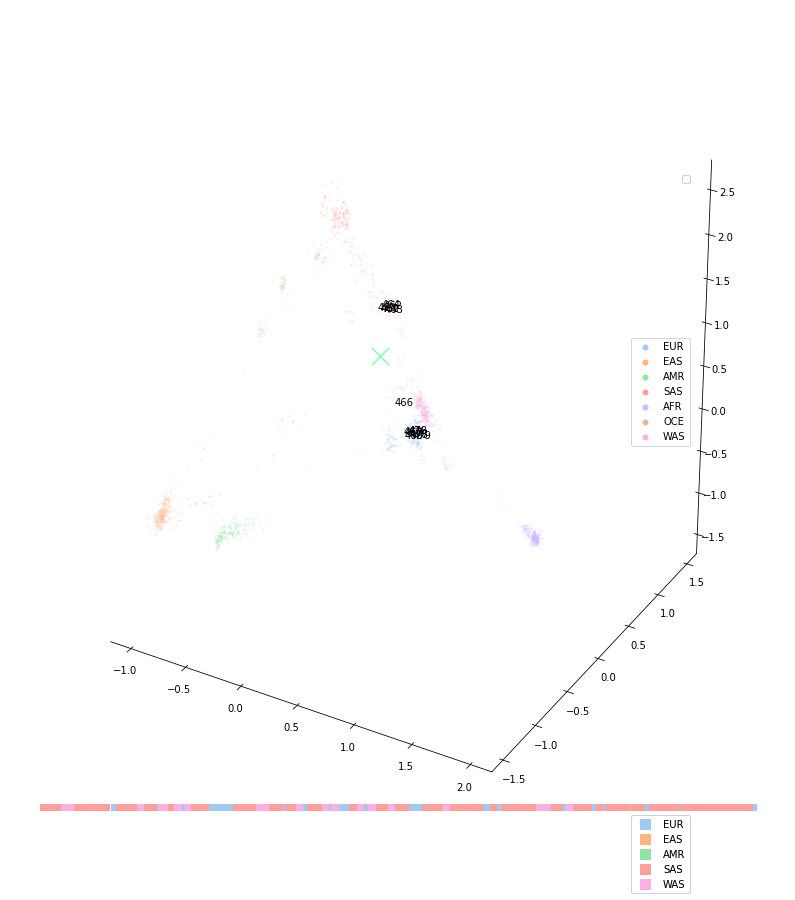

In [295]:
index=1245
y_pred_overall = valid_outs.coord_main[index,:]
all_labels=np.stack(list(labels_dict.values()))
y_target_labels=val_target_labels.detach().cpu().numpy()[index,:]
y_vcf_labels = torch.tensor(val_vcf_idx[index,0:params.chmlen].reshape(1,params.n_win, params.aux_net_in))
y_vcf_idx = torch.mode(y_vcf_labels,dim=2)[0]
y_vcf_idx = y_vcf_idx.detach().cpu().numpy()
pop_order=list(superpop_dict.keys())
plot_sample(y_pred_overall,y_vcf_idx,y_target_labels, pop_arr,rev_pop_dict,superpop_dict,all_labels, \
            config['data.labels_dir'],cp_show=False)

In [41]:
all_preds=valid_outs.coord_main
all_vcf_labels = torch.tensor(val_vcf_idx[:,0:params.chmlen].reshape(-1,params.n_win, params.aux_net_in))
all_vcf_idx = torch.mode(all_vcf_labels,dim=2)[0]
all_vcf_idx = all_vcf_idx.detach().cpu().numpy().reshape(-1,1)
continent_map = {k:v for k,v in zip(pop_arr[:,1], pop_arr[:,3])}
continent_labels = np.array(list(map(lambda x: continent_map[x.item()], all_vcf_idx)))

In [42]:
vcf_labels = torch.tensor(val_vcf_idx[:,0:params.chmlen].reshape(-1,params.n_win, params.aux_net_in))
vcf_idx = torch.mode(vcf_labels,dim=2)[0]
all_vcf_idx_w_reshape = vcf_idx.detach().cpu().numpy()

In [43]:
all_vcf_idx_w_reshape.shape

(3650, 605)

In [83]:
all_preds.shape

(3650, 605, 3)

In [263]:
np.unique(np.where(np.isin(all_vcf_idx_w_reshape,[7104, 7105,7106, 7107]))[0])

array([1244, 1245, 1424, 1486, 1782, 1824, 1894, 1947, 1979, 2037, 2111,
       2219, 2237, 2241, 2248, 2304, 2320, 2349, 2400, 2442, 2492, 2509,
       2536, 2604, 2729, 2779, 2793, 2957, 2961, 2967, 2977, 3004, 3022,
       3035, 3097, 3114, 3136, 3179, 3220, 3257, 3268, 3307, 3320, 3324,
       3327, 3328, 3355, 3377, 3393, 3396, 3402, 3418, 3458, 3474, 3572,
       3576, 3589, 3593, 3613, 3628])

In [115]:
np.unique(np.where(all_vcf_idx_w_reshape == 1144)[0])

array([], dtype=int64)

In [129]:
def getSuperpopBins(pop_arr, labels_path, preds):
    """
    compute distance of preds from labels and assign the bin to the closest label
    """
    labels=load_path(osp.join(labels_path, 'labels.pkl'), en_pickle=True)
    labels_npy=np.array(list(labels.values())) #5930x3
    preds=preds[:,np.newaxis,:]
    preds=np.repeat(preds,labels_npy.shape[0], axis=1) #(100x605)x5930x3
    L2Matrix=np.sum(np.square(preds-labels_npy), axis=2) #(100x605)x5930
    idx=np.argmin(L2Matrix, axis=1)#60500

    # use these idxes to find the mapped superpop bin
    dict_idx={k:v for k,v in zip(range(len(labels)), list(labels.keys()))}
    ref_idx=list(map(lambda x:dict_idx[x], idx))
    mappedSp=list(map(lambda x:getValueBySelection(pop_arr,1,x,3),ref_idx))
    mappedSpArr=np.array(mappedSp).reshape(-1,n_win)
    return mappedSpArr

In [105]:
mappedSpArr=getSuperpopBins(pop_arr, config['data.labels_dir'], all_preds[1208:1209,:].reshape(-1,3))

(5930, 3)
(605, 5930, 3)
(605, 5930)
(605,)
605


In [106]:
mappedSpArr.shape, mappedSpArr

((1, 605),
 array([[3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
         5, 5, 5, 1, 1, 3, 3, 3, 3, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 5, 5, 5, 5, 5, 3, 3, 3, 5, 3, 5,
         5, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         1, 1, 1, 1, 1, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 3, 1, 1, 1, 1, 3, 3, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1,
         1, 3,

In [107]:
superpop_dict

{'AFR': 4, 'AMR': 2, 'EAS': 1, 'EUR': 0, 'OCE': 5, 'SAS': 3, 'WAS': 6}

In [158]:
len([i for i in continent_labels if i==4]), all_vcf_idx.shape

(25096, (115200, 1))

In [159]:
np.nonzero(continent_labels==0)[0]

array([    26,     27,     48, ..., 115187, 115188, 115189])

In [160]:
continent_labels

array([1, 1, 1, ..., 1, 1, 3])

In [395]:
test_all_preds=test_outs.coord_main
test_all_vcf_labels = torch.tensor(test_vcf_idx[:,0:params.chmlen].reshape(-1,params.n_win, params.aux_net_in))
test_all_vcf_idx = torch.mode(test_all_vcf_labels,dim=2)[0]
test_all_vcf_idx = test_all_vcf_idx.detach().cpu().numpy().reshape(-1,1)
continent_map = {k:v for k,v in zip(pop_arr[:,1], pop_arr[:,3])}
continent_labels = np.array(list(map(lambda x: continent_map[x.item()], test_all_vcf_idx)))

In [161]:
def plot_all_preds(superpop_dict, continent_labels, all_preds):
    mpl.rcParams['axes.spines.left'] = False
    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.bottom'] = False
    fig, ax = plt.subplots(figsize=(14,15))
    plt.xticks([])
    plt.yticks([])
    gs1 = fig.add_gridspec(nrows=1, ncols=1)
    ax=fig.add_subplot(gs1[0:,:],projection='3d')

    colors_pop_all = sns.color_palette("tab10", len(superpop_dict))
    plot1=[]
    for k,i in superpop_dict.items():
        idx_label = np.nonzero(continent_labels==i)[0]
        plot1.append(ax.scatter(all_preds[idx_label,0], all_preds[idx_label,1], all_preds[idx_label,2], s=0.005,\
                color=colors_pop_all[i] ,label = k))
    lgnd1 = ax.legend(handles=plot1,bbox_to_anchor=(0.88,0.6))
    for l in lgnd1.legendHandles:
        l.set_alpha(1.0)
        l._sizes = [100]
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.add_artist(lgnd1)
    plt.show()

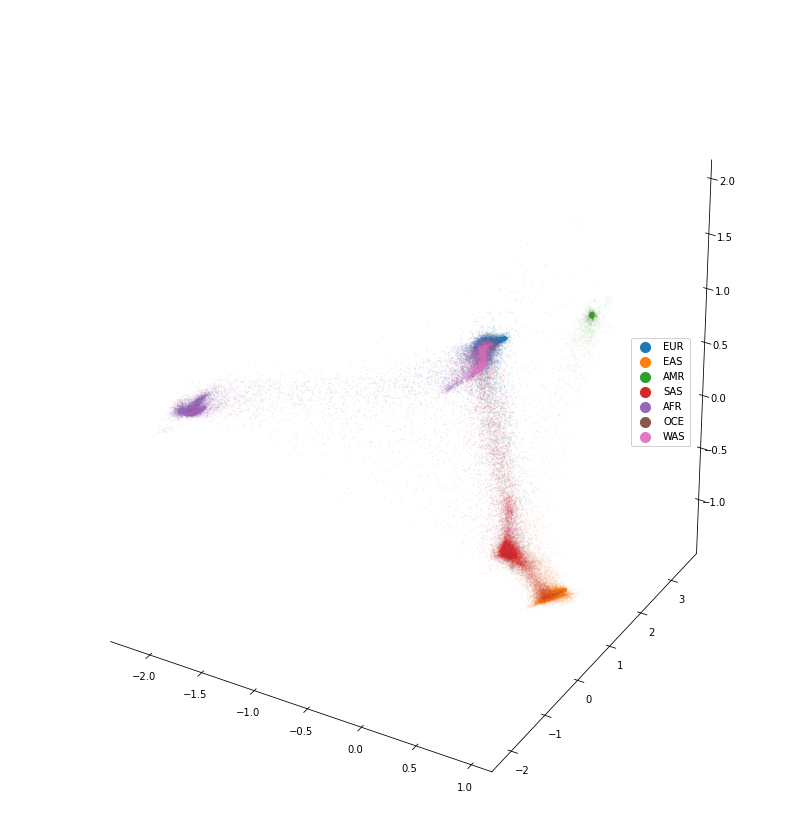

In [162]:
plot_all_preds(superpop_dict, continent_labels, all_preds.reshape(-1,3))

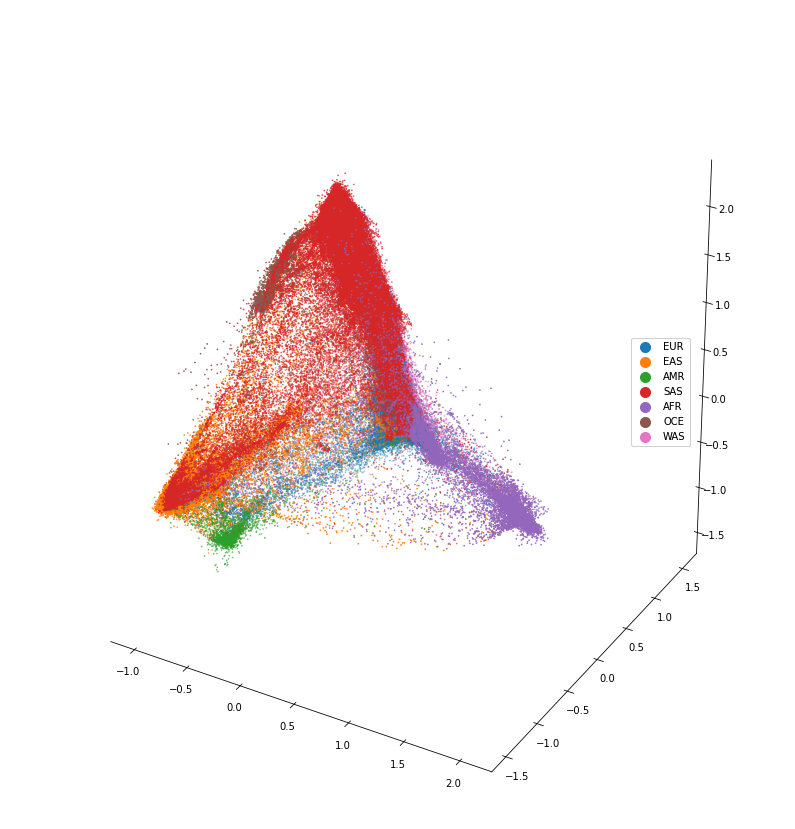

In [398]:
plot_all_preds(superpop_dict, continent_labels, test_all_preds.reshape(-1,3))

In [308]:
all_preds.shape, pop_arr_valid.shape,all_preds.reshape(-1,3).shape

((3650, 317, 3), (1250, 4), (1157050, 3))

In [310]:
y_vcf_idx.shape

(1, 317)

In [117]:
np.stack(list(labels_dict.values())).shape

(5930, 3)

In [69]:
y_pred_overall.shape, y_vcf_idx.shape, y_target_labels.shape

((317, 3), (317410,), (317, 3))

In [31]:
def plot(y_vcf_idx, y_pred, PCA_lbls_dict, pop_arr, pop_dict, target_labels_idx):

    fig=plt.figure(figsize=(10,12))
    plt.rcParams['savefig.transparent'] = True
    ax= Axes3D(fig)
    ax = fig.gca(projection='3d')

    num_labels_idx = np.unique(y_vcf_idx)
    print(f'num_labels_idx:{num_labels_idx}')
    colors1 = sns.color_palette("rainbow", len(num_labels_idx))
    j =0
    rev_pop_dict = {v:k for k,v in pop_dict.items()}
    
    gradient_cp_idx = np.unique(np.where(abs(y_pred[:-1,:]-y_pred[1:,:])>0.3)[0])
    print(f'gradient_cp_idx:{gradient_cp_idx}')

    
    for i, val in enumerate(num_labels_idx):
        idx_label = np.nonzero(y_vcf_idx==val)[0]
        pop_arr_idx = np.where(pop_arr[:,1]==val)[0][0]
        granular_pop = pop_arr[pop_arr_idx,2]
       
        ax.scatter(y_pred[idx_label,0], y_pred[idx_label,1], y_pred[idx_label,2], s=55\
                  ,color=colors1[j], label = rev_pop_dict[granular_pop] )
#         ax.scatter(PCA_lbls_dict[val][0], PCA_lbls_dict[val][1], PCA_lbls_dict[val][2], s=55\
#                   ,color=colors1[j], marker='X')  
        ax.scatter(target_labels_idx[idx_label,0], target_labels_idx[idx_label,1], target_labels_idx[idx_label,2],\
                   s=155, color=colors1[j], marker='X')
        #ax.scatter(PCA_labels_chm22[val][0], PCA_labels_chm22[val][1], PCA_labels_chm22[val][2], s=550\
                  #,color=colors1[j], marker='s') 
        j +=1

        lgnd = ax.legend(bbox_to_anchor=(0.9,0.5+(i/20)))
        for l in lgnd.legendHandles:
            l._sizes = [30]

        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        #ax.view_init(azim=-90, elev=19)
    
    ax.scatter(y_pred[gradient_cp_idx,0], y_pred[gradient_cp_idx,1], y_pred[gradient_cp_idx,2], s=100,\
           color='black', marker='v')
    plt.show()

In [26]:
def repeat_pop_arr(sample_map):
    """
    This function maps from ref idx of sample map
    to ref idx of vcf file by repeating for 2*i and 2*i+1
    """
    pop_arr = sample_map.values[:, np.newaxis, :]
    pop_arr = np.repeat(pop_arr, 2, axis=1)
    pop_arr = pop_arr.reshape(2*len(sample_map),-1)
    pop_arr[:,1] = [i for x in sample_map.values[:,1] for i in (2*x, 2*x+1)]
    return pop_arr

(81, 1) (81, 3)
num_labels_idx:[362.]
gradient_cp_idx:[ 0  4  7 21 23 26 32 34 35 38 39 41 42 43 44 45 46 50 51 52 53 55 57 58
 59 60 62 63 64 66 67 68 69 70 71 72 73 74 75 76 78 79]


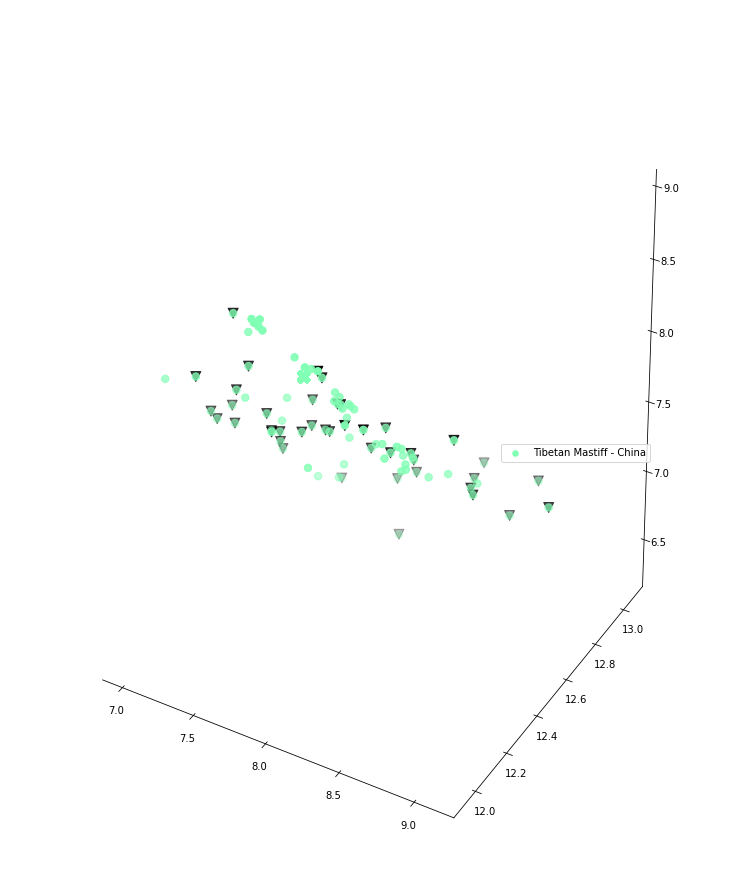

In [66]:
index = 80

path_prefix = osp.join(str(config['data.data_out']), config['geno_type'], \
                       ''.join(['sm_', config['data.sample_map']]),\
                    config['train.experiment_name'], str(config['train.experiment_id']))
    
y_vcf_labels = torch.tensor(val_labels[index,0:params.chmlen].reshape(1,params.n_win, params.aux_net_in)).float()
y_vcf_idx = torch.mode(y_vcf_labels,dim=2)[0]
y_vcf_idx = y_vcf_idx.detach().cpu().numpy()
y_pred_index = y_pred[index,:,:]
y_pred_index_np = y_pred_index.detach().cpu().numpy()
PCA_lbls_dict = load_path(osp.join(labels_path, 'Umap/labels.pkl'), en_pickle=True)
granular_pop_dict = load_path(osp.join(path_prefix, 'granular_pop.pkl'), en_pickle=True)

val_target_labels_idx = val_target_labels[index,:,:].detach().cpu().numpy().reshape(-1,params.dataset_dim)

# get pop_arr
pop_sample_map = pd.read_csv(osp.join(path_prefix, 'pop_sample_map.tsv'), sep="\t")
pop_arr = repeat_pop_arr(pop_sample_map)
        
# stack the target and pred 
y_vcf_idx = y_vcf_idx.reshape(-1,1)
y_pred_index_np = y_pred_index_np.reshape(-1, params.rnn_net_out)
print(y_vcf_idx.shape, y_pred_index_np.shape)

plot(y_vcf_idx, y_pred_index_np, PCA_lbls_dict, pop_arr,granular_pop_dict, val_target_labels_idx)

In [54]:
y_pred_index_np.shape

(81, 3)

In [64]:
rev_pop_dict

{0: 'Retriever',
 1: 'Husky',
 2: 'Hound',
 3: 'Terrier',
 4: 'Basenji',
 5: 'East',
 6: 'Greyhound',
 7: 'Tibetan_Mastiff'}

In [62]:
pop_arr[:,1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 20

In [46]:
y_labels = torch.tensor(val_labels[:,0:params.chmlen].reshape(-1,params.n_win, params.aux_net_in)).float()
y_vcf_labels = torch.mode(y_labels,dim=2)[0]
y_vcf_labels = y_vcf_labels.detach().cpu().numpy()
y_vcf_labels.shape
y_vcf_labels_flatten = y_vcf_labels.reshape(-1,1)
y_vcf_labels_flatten.shape

(201366, 1)

In [47]:
continent_map = {k:v for k,v in zip(pop_arr[:,1], pop_arr[:,2])}
# granular_pop_map = {k:v for k,v in zip(pop_arr[:,1], pop_arr[:,2])}
continent_labels = list(map(lambda x: continent_map[x.item()], y_vcf_labels_flatten.reshape(-1,1)))
# granular_pop_labels = list(map(lambda x: granular_pop_map[x.item()], y_vcf_labels_flatten.reshape(-1,1)))
superpop_dict = load_path(osp.join(path_prefix, 'superpop.pkl'), en_pickle=True)
rev_superpop_dict = {k:v for v,k in superpop_dict.items()}
# rev_pop_dict = {v:k for k,v in granular_pop_dict.items()}

In [48]:
y_pred_np = y_pred.detach().cpu().numpy()
embedding_vec = y_pred_np
gradient_cp_idx = np.where(abs(embedding_vec[:,:-1,:]-embedding_vec[:,1:,:])>0.3)
print(f'gradient_cp_idx:{gradient_cp_idx}')
mask_gradient = (abs(embedding_vec[:,:-1,:]-embedding_vec[:,1:,:])>0.3).astype(int)
mask_gradient = np.amax(mask_gradient, axis=2)
# add 0 at the end
mask_gradient = np.hstack((mask_gradient, np.zeros_like(mask_gradient[:,0].reshape(-1,1))))
mask_gradient.shape, mask_gradient[0,19], mask_gradient.sum(), (~mask_gradient).sum()

gradient_cp_idx:(array([   0,    0,    0, ..., 2485, 2485, 2485]), array([ 0,  0,  1, ..., 76, 78, 79]), array([0, 1, 0, ..., 2, 0, 1]))


((2486, 81), 0, 72814, -274180)

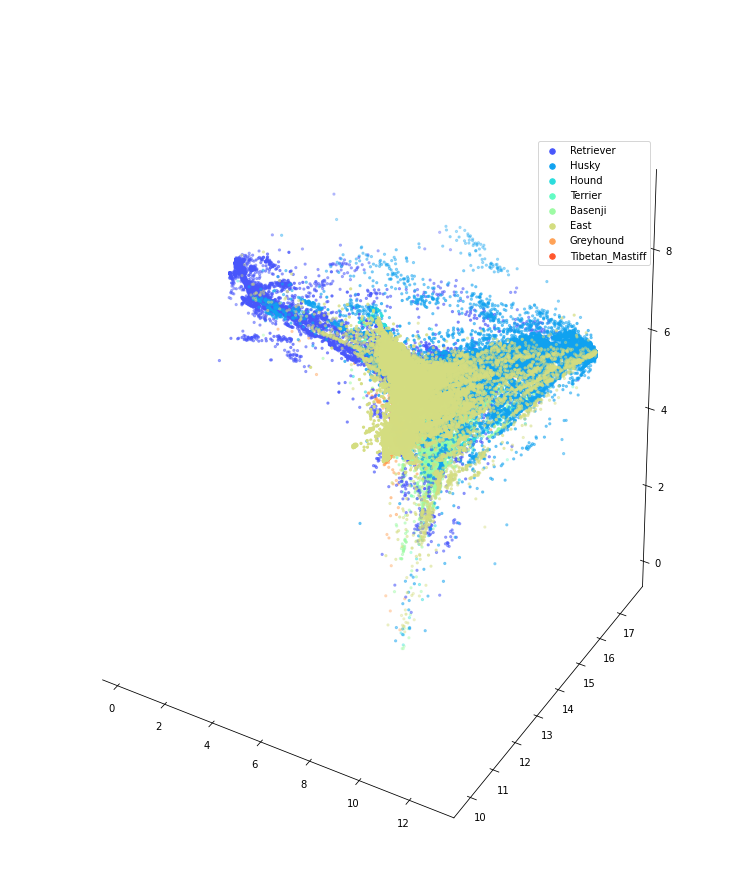

In [53]:
embedding_vec = y_pred_np
embedding_vec_flatten = embedding_vec[:,:,0:3].reshape(-1,3)

fig=plt.figure(figsize=(10,12))
plt.rcParams['savefig.transparent'] = True
ax= Axes3D(fig)
ax = fig.gca(projection='3d')

# colors1=['#0000ff','#008000', '#ff6dff', '#a3fecb', '#fffe58','#fc6500','#800080', '#ccccfe', '#4c4cfe', '#feccfe', '#000033', '#00fff2']
pop = list(superpop_dict.keys())
colors1 = sns.color_palette("rainbow", len(pop))

color_pop_dict = {k:v for k,v in zip(pop, colors1)}

j =0
rev_pop_dict = {v:k for k,v in superpop_dict.items()}



for i in np.arange(8):
    idx = np.nonzero(continent_labels==i)[0]
    ax.scatter(embedding_vec_flatten[idx,0], embedding_vec_flatten[idx,1], embedding_vec_flatten[idx,2], \
               color = colors1[j], s= 5, label = rev_superpop_dict[i])
#     text_idx = np.random.choice(idx,18)
#     for k in text_idx:
#         val_granular_pop=granular_pop_labels[k]
#         ax.text( embedding_vec_flatten[k,0], embedding_vec_flatten[k,1], embedding_vec_flatten[k,2], \
#                 s = rev_pop_dict[val_granular_pop])
    j +=1
    lgnd = ax.legend(bbox_to_anchor=(0.9,0.5+(i/20)))
    for l in lgnd.legendHandles:
        l._sizes = [30]

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#     ax.set_xlim(-2,2)
#     ax.set_ylim(-2,2)
#     ax.set_zlim(-2,2)
    

# ax.scatter(embedding_vec[gradient_cp_idx[0], gradient_cp_idx[1],0], \
#            embedding_vec[gradient_cp_idx[0],gradient_cp_idx[1], 1], \
#            embedding_vec[gradient_cp_idx[0],gradient_cp_idx[1],2], s=0.5,\
#            color='white', marker='v')
plt.show()